In [132]:
# importing helper libraries
import numpy as np
import pandas as pd
# import machine learning libraries
import tensorflow as tf
from tensorflow import keras
# Importing data preprocessing techniques
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Data Reading, Downloaded from Yahoo Finance

In [133]:
data = pd.read_csv("../BTC-USD.csv")
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [134]:
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [135]:
# we need to remove null or NaN value from our dataset
data.dropna(inplace = True)
data.isna().astype("int").sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [136]:
required_data = data[["High", "Low", "Close"]]
required_data.head()

,High,Low,Close
0,468.174011,452.421997,457.334015
1,456.859985,413.104004,424.440002
2,427.834991,384.532013,394.795990
3,423.295990,389.882996,408.903992
4,412.425995,393.181000,398.821014


# Data Preprocessing

Use the data before 3/19/2024 for training, and 3/19/2024 to 5/19/2024 for testing

In [137]:
idx_split = data[data.Date == "2024-03-19"].index[0]
idx_split

3471

In [138]:
# train_data_length = int(0.9 * len(required_data))
train_data_length = idx_split
print(f"training data fraction : {train_data_length/len(required_data)}")

training data fraction : 0.9827293318233296


In [139]:
# Before we normalize the data, we need to split the data into train and test split, so that data snooping can be
# avoided

train_data = required_data.iloc[:train_data_length]
test_data = required_data.iloc[train_data_length:]

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3471, 3)
Testing data : (61, 3)


In [140]:
# Data Normalization
# This will scale the data between -1 and 1
normalizer = MinMaxScaler(feature_range = (-1, 1))
# Fit the normalizer on the train data only
normalizer.fit(train_data)

# converting the train data
train_data = normalizer.transform(train_data)
test_data  = normalizer.transform(test_data)

print(f"Training data : {train_data.shape}")
print(f"Testing data : {test_data.shape}")

Training data : (3471, 3)
Testing data : (61, 3)


In [141]:
# checking the range of train data and test data
print(f"Maximum and minimum value of training data : {np.max(train_data), np.min(train_data)}")
print(f"Maximum and minimum value of testing  data : {np.max(test_data), np.min(test_data)}")

Maximum and minimum value of training data : (1.0, -1.0)
Maximum and minimum value of testing  data : (0.971859279181212, 0.5846468747711364)


In [142]:
# this piece of code creates the data where features and targets are multivariate

def create_window_split_with_target_multivariate(data, window_size, horizon=1, stride=1):
    """
    Function to split a multivariate time series data into overlapping windows and generate target variables.
    
    Parameters:
        data (numpy.ndarray): The input multivariate time series data with shape (num_samples, num_features).
        window_size (int): Size of each window.
        horizon (int): Forecast horizon, i.e., number of future time steps to predict. Default is 1.
        stride (int): The stride or step size between consecutive windows. Default is 1.
    
    Returns:
        numpy.ndarray, numpy.ndarray: Arrays containing the split windows and corresponding target variables.
    """
    num_samples = len(data)
    num_features = data.shape[1]
    num_windows = (num_samples - window_size - horizon) // stride + 1
    windows = np.zeros((num_windows, window_size, num_features))
    targets = np.zeros((num_windows, num_features))
    
    for i in range(num_windows):
        start_index = i * stride
        end_index = start_index + window_size
        windows[i] = data[start_index:end_index]
        targets[i] = data[end_index + horizon - 1]  # Assuming the target is the value at the end of the forecast horizon
    
    return windows, targets


window_size = 15
horizon = 1
stride = 1

train_features, train_lables = create_window_split_with_target_multivariate(train_data, window_size, horizon, stride)
test_features, test_lables = create_window_split_with_target_multivariate(test_data, window_size, horizon, stride)


print(f"Training Data : {train_features.shape, train_lables.shape}")
print(f"Testing Data : {test_features.shape, test_lables.shape}")

Training Data : ((3456, 15, 3), (3456, 3))
Testing Data : ((46, 15, 3), (46, 3))


# Model Training and Evaluation

## GRU Models

Model 1: This model has 2 GRU layers with 128 units each and Group Normalization

In [148]:
from tensorflow.keras.layers import GRU

gru128 = tf.keras.Sequential(
    [
        keras.layers.Input(shape = (15, 3)),
        GRU(units = 128, activation = "gelu", return_sequences = True),
        keras.layers.GroupNormalization(),
        GRU(units = 128, activation = "gelu"),
        keras.layers.GroupNormalization(),
        keras.layers.Dense(units=64, activation="gelu"),
        keras.layers.Dense(units=3, activation="tanh")  
    ]
)
gru128.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, 15, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_16          │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_17          │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,107 (621.51 KB)

 Trainable params: 159,107 (621.51 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
gru128b = tf.keras.Sequential(
    [
        keras.layers.Input(shape = (15, 3)),
        keras.layers.Bidirectional(GRU(units=128, activation="gelu", return_sequences=True)),
        keras.layers.GroupNormalization(),
        keras.layers.Bidirectional(GRU(units=128, activation="gelu")),
        keras.layers.GroupNormalization(),
        keras.layers.Dense(units=64, activation="gelu"),
        keras.layers.Dense(units=3, activation="tanh")  
    ]
)
gru128.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_18 (GRU)                    │ (None, 15, 128)        │        51,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_16          │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_19 (GRU)                    │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_17          │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,107 (621.51 KB)

 Trainable params: 159,107 (621.51 KB)

 Non-trainable params: 0 (0.00 B)

detect if the model has converge early

Model 2: This model has 2 GRU layers with 32 units each and Layer Normalization

In [150]:
gru32 = tf.keras.Sequential(
    [
        keras.layers.Input(shape=(15, 3)),
        GRU(units=32, activation="tanh", return_sequences=True),
        keras.layers.LayerNormalization(),
        GRU(units=32, activation="tanh"),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(units=32, activation="tanh"),
        keras.layers.Dense(units=3)  
    ]
)
gru32.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_22 (GRU)                    │ (None, 15, 32)         │         3,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 15, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_23 (GRU)                    │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171 (43.64 KB)

 Trainable params: 11,171 (43.64 KB)

 Non-trainable params: 0 (0.00 B)

In [151]:
gru32b = tf.keras.Sequential(
    [
        keras.layers.Input(shape=(15, 3)),
        keras.layers.Bidirectional(GRU(units=32, activation="tanh", return_sequences=True)),
        keras.layers.LayerNormalization(),
        keras.layers.Bidirectional(GRU(units=32, activation="tanh")),
        keras.layers.LayerNormalization(),
        keras.layers.Dense(units=32, activation="tanh"),
        keras.layers.Dense(units=3)  
    ]
)
gru32b.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 15, 64)         │         7,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_12          │ (None, 15, 64)         │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 64)             │        18,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_13          │ (None, 64)             │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,355 (110.76 KB)

 Trainable params: 28,355 (110.76 KB)

 Non-trainable params: 0 (0.00 B)

Model 3: RNN Model

In [152]:
rnn = tf.keras.Sequential(
    [
        keras.layers.Input(shape=(15, 3)),
        keras.layers.RNN(
            keras.layers.SimpleRNNCell(units=128, activation="gelu"),
            return_sequences=True
        ),
        keras.layers.GroupNormalization(),
        keras.layers.RNN(
            keras.layers.SimpleRNNCell(units=128, activation="gelu"),
        ),
        keras.layers.GroupNormalization(),
        keras.layers.Dense(units=64, activation="gelu"),
        keras.layers.Dense(units=3, activation="tanh")
    ]
)
rnn.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rnn_8 (RNN)                     │ (None, 15, 128)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_20          │ (None, 15, 128)        │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_9 (RNN)                     │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_21          │ (None, 128)            │           256 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,755 (229.51 KB)

 Trainable params: 58,755 (229.51 KB)

 Non-trainable params: 0 (0.00 B)

In [154]:
callbacks = []
early_stops = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40)
callbacks.append(early_stops)

In [155]:
models = [gru128, gru128b, gru32, gru32b, rnn]
model_names = ["gru128", "gru128b", "gru32", "gru32b", "rnn"]

train all models

In [157]:
histories = []
for model, name in zip(models, model_names):
    model.compile(optimizer=keras.optimizers.AdamW(learning_rate = 0.001), loss = "mse", metrics = ["mse", "mae"])
    history = model.fit(train_features, train_lables, epochs=100, validation_split=0.1, callbacks=callbacks + [tf.keras.callbacks.ModelCheckpoint(f"{name}.keras", save_best_only=True)])
    histories.append(history)

Epoch 1/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1714 - mae: 0.2473 - mse: 0.1714 - val_loss: 0.0078 - val_mae: 0.0732 - val_mse: 0.0078
Epoch 2/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - mae: 0.0400 - mse: 0.0026 - val_loss: 0.0027 - val_mae: 0.0362 - val_mse: 0.0027
Epoch 3/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - mae: 0.0214 - mse: 0.0011 - val_loss: 0.0031 - val_mae: 0.0445 - val_mse: 0.0031
Epoch 4/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.2065e-04 - mae: 0.0189 - mse: 8.2065e-04 - val_loss: 0.0040 - val_mae: 0.0492 - val_mse: 0.0040
Epoch 5/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9.5976e-04 - mae: 0.0195 - mse: 9.5976e-04 - val_loss: 0.0056 - val_mae: 0.0605 - val_mse: 0.0056
Epoch 6/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.5268e-04 - mae: 0.0198 - mse: 9.5268e-04 - val_loss: 0.0041 - val_mae: 0.0531 - val_mse: 0.0041
Epoch 7/100
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.3965e-04 - mae

## Training progress

In [163]:
def plot_training_progress(histories, model_names):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for history, name in zip(histories, model_names):
        train_loss = history.history["loss"]
        valid_loss = history.history["val_loss"]
        
        train_mae = history.history["mae"]
        valid_mae = history.history["val_mae"]
    
        axes[0].plot(range(len(valid_loss)), valid_loss, label=name)
        axes[1].plot(range(len(valid_mae)), valid_mae, label=name)
        axes[2].plot(range(len(train_loss)), train_loss, label=name)    
        axes[3].plot(range(len(train_mae)), train_mae, label=name)
    axes[0].set_title("Validation MSE vs Epochs")
    axes[1].set_title("Validation MAE vs Epochs")
    axes[2].set_title("Training MSE vs Epochs")
    axes[3].set_title("Training MAE vs Epochs")
    axes[0].set_ylabel("Loss value")
    for ax in axes:
        ax.set_xlabel("Epoch") 
        ax.set_yscale("log")
    axes[0].legend()
    plt.show()

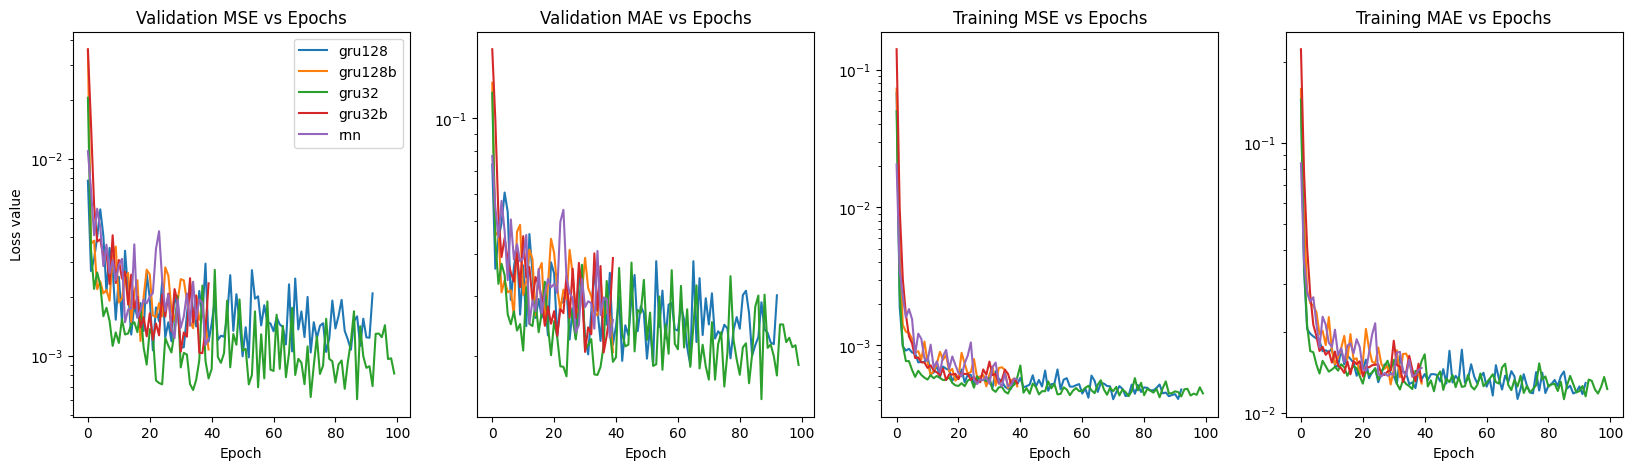

In [164]:
plot_training_progress(histories, model_names)

save the best model

In [127]:
import matplotlib.pyplot as plt

In [128]:
def plot(models, model_names):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    # true values
    axes[0].plot(test_lables[:, 0], label = "True")
    axes[1].plot(test_lables[:, 1], label = "True")
    axes[2].plot(test_lables[:, 2], label = "True")
    for model, name in zip(models, model_names):
        test_predicts = model.predict(test_features)
        
        axes[0].plot(test_predicts[:, 0], label=name, linestyle="--")
        axes[0].set_title('High Value')
        axes[0].set_xlabel('Future Dates')
        axes[0].set_ylabel('Predicted values')
        
        axes[1].plot(test_predicts[:, 1], label=name, linestyle="--")
        axes[1].set_title('Low Value')
        axes[1].set_xlabel('Future Dates')
        axes[1].set_ylabel('Predicted values')
        
        axes[2].plot(test_predicts[:, 2], label=name, linestyle="--")
        axes[2].set_title('Close Value')
        axes[2].set_xlabel('Future Dates')
        axes[2].set_ylabel('Predicted values')
    for ax in axes:
        ax.legend()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f06b3233f60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


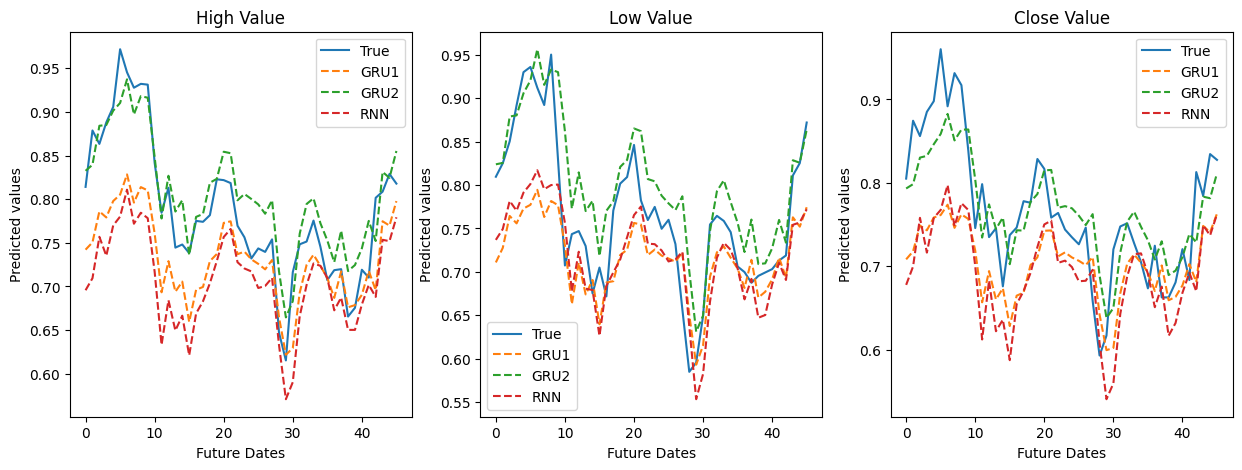

In [129]:
plot([gru1, gru2, rnn], ["GRU1", "GRU2", "RNN"])


In [25]:
import tensorflow as tf

In [26]:
tf.__version__

'2.16.1'